<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if running in Google Colab
try:
  from google.colab import drive
  running_in_colab = True
except ImportError:
  running_in_colab = False

In [ ]:
if running_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install detectron

In [ ]:
if running_in_colab:
    #!python -m pip install pyyaml==5.1
    import sys, os, distutils.core
    # Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
    # See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
    #!git clone 'https://github.com/facebookresearch/detectron2'
    #dist = distutils.core.run_setup("./detectron2/setup.py")
    #!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
    sys.path.insert(0, os.path.abspath('./detectron2'))

    # Path to the Detectron2 directory in your Google Drive
    detectron2_path = "/content/drive/MyDrive/detectron2"
    sys.path.append(detectron2_path)

# Install other packages

In [ ]:
if running_in_colab:
  # Change directory to your Google Drive
  %cd /content/drive/MyDrive/

  # Clone the Detectron2 repository
  #!git clone https://github.com/facebookresearch/detectron2.git

  # Change directory to the cloned repository
  %cd detectron2

  # Install Detectron2 (the -e flag means "editable mode", so changes to the code will immediately take effect)
  !pip install -e .

/content/drive/MyDrive
/content/drive/MyDrive/detectron2
Obtaining file:///content/drive/MyDrive/detectron2
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Attempting uninstall: iopath
    Found existing installation: iopath 0.1.10
    Uninstalling iopath-0.1.10:
      Successfully uninstalled iopath-0.1.10
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2


In [ ]:
!pip install --upgrade pillow

In [ ]:
!pip install --upgrade iopath

  Using cached iopath-0.1.10-py3-none-any.whl
  Attempting uninstall: iopath
    Found existing installation: iopath 0.1.9
    Uninstalling iopath-0.1.9:
      Successfully uninstalled iopath-0.1.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
detectron2 0.6 requires iopath<0.1.10,>=0.1.7, but you have iopath 0.1.10 which is incompatible.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
if running_in_colab:
    !pip install --upgrade OWSLib geopandas rasterio shapely
#!pip install pytorchtools

# Import packages and prep

In [ ]:
# import packages
import os
import numpy as np
import cv2
from shapely.geometry import Polygon
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import box

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
import os
import pandas as pd
import json

# Default local paths
model_label = "model_aoi400_5816_70p_8000i_augm_cfg2"

model_name = f"{model_label}.pth"

data_folder = "/content/drive/MyDrive/data/400_5816/"

satellite_folder = os.path.join(data_folder, 'sliced_output_2020S')
vector_folder = os.path.join(data_folder, 'crowns')
coverage_csv_path = os.path.join(data_folder, 'coverage.csv')
transform_matrix_path = os.path.join(data_folder, 'transform_matrix.txt')
transform_json_path = os.path.join(data_folder, 'transform.json')
model_path = os.path.join(data_folder, 'models/')

# Load coverage.csv and filter based on threshold
coverage_df = pd.read_csv(coverage_csv_path, delimiter=';')
valid_files_base = coverage_df[coverage_df['coverage'] > 70]['filename'].tolist()

# Append the extensions for image and vector files
valid_satellite_files = [f + ".tif" for f in valid_files_base]
valid_vector_files = [f + ".geojson" for f in valid_files_base]

# Filter satellite images and vectors based on valid files
satellite_images = [os.path.join(satellite_folder, f) for f in os.listdir(satellite_folder) if f in valid_satellite_files]
vector_layers = {os.path.splitext(f)[0]: os.path.join(vector_folder, f) for f in os.listdir(vector_folder) if f in valid_vector_files}

# Ensure the paths exist
for folder in [model_path, satellite_folder, vector_folder]:
    if not os.path.exists(folder):
        raise FileNotFoundError(f"The folder {folder} does not exist")

# Print valid files vs total files for vector layers
total_geojson_files = len([f for f in os.listdir(vector_folder) if f.endswith(".geojson")])
total_tif_files = len([f for f in os.listdir(satellite_folder) if f.endswith(".tif")])
print(f"{len(vector_layers)} valid vector files out of {total_geojson_files} total vector files and {total_tif_files} total satellite images.")



111 valid vector files out of 400 total vector files and 400 total satellite images.



# Prepare training data

In [ ]:
transform_data = {}

if satellite_images:
    # Loop through each valid satellite image
    for image_path in satellite_images:
        with rasterio.open(image_path) as src:
            transform = src.transform
            crs = src.crs.to_string()
            bounds = src.bounds
            image_name = os.path.basename(image_path)

            transform_data[image_name] = {
                'transform': list(transform),
                'crs': crs,
                'bounds': bounds,
            }

    # Save all transformation matrices and CRS to a JSON file
    with open(transform_json_path, 'w') as f:
        json.dump(transform_data, f)
    print(f"Transformation matrices and CRS saved to {transform_json_path}")
else:
    print("No valid satellite images found.")

Transformation matrices and CRS saved to /content/drive/MyDrive/data/400_5816/transform.json


In [ ]:
# Serialize and save as JSON
transform_data = {"transform": list(src.transform)}
with open(transform_json_path, "w") as f:
    json.dump(transform_data, f)

In [ ]:
def get_length_width(polygon):
    if polygon.is_empty or polygon.geom_type != 'Polygon':
        return None, None

    # Get the coordinates of the polygon and subtract the mean
    coords = np.array(polygon.exterior.coords)
    coords -= coords.mean(axis=0)

    # Perform PCA on the coordinates
    pca = PCA(2)
    coords_pca = pca.fit_transform(coords)

    # Create a new polygon using the transformed coordinates
    polygon_pca = Polygon(coords_pca)

    # The length and width of the polygon are the difference between the maximum
    # and minimum x and y values, respectively
    length = polygon_pca.bounds[2] - polygon_pca.bounds[0]
    width = polygon_pca.bounds[3] - polygon_pca.bounds[1]

    # return max and min as length and width
    return max(length, width), min(length, width)

def satisfies_ratio(polygon):
    length, width = get_length_width(polygon)
    if width == 0:  # To avoid division by zero
        return False
    ratio = length / width
    return ratio <= 2.4


In [ ]:
def vector_to_mask(polygon, image_shape, transform):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if not polygon.empty:
        for idx, geom in enumerate(polygon):
            if geom is None:
                continue  # Skip this iteration if geom is None
            if geom.type == 'Polygon':
                if not satisfies_ratio(geom):
                  continue
                coords = np.array([geom.exterior.coords])
                coords_reshaped = coords.reshape(-1, 2)
                rows, cols = rasterio.transform.rowcol(transform, coords_reshaped[:, 0], coords_reshaped[:, 1])
                coords_t = np.column_stack((cols, rows)).astype(np.int32)
                cv2.fillPoly(mask, [coords_t], idx+1)
            elif geom.type == 'MultiPolygon':
                for poly_idx, poly in enumerate(geom.geoms):
                    if not satisfies_ratio(poly):
                      continue
                    coords = np.array([poly.exterior.coords])
                    coords_reshaped = coords.reshape(-1, 2)
                    rows, cols = rasterio.transform.rowcol(transform, coords_reshaped[:, 0], coords_reshaped[:, 1])
                    coords_t = np.column_stack((cols, rows)).astype(np.int32)
                    cv2.fillPoly(mask, [coords_t], idx+1+poly_idx)
            else:
                raise ValueError('Unknown geometry type: ' + geom.type)
    return mask

In [ ]:
import warnings
import rasterio
import cv2
import geopandas as gpd
import os
import numpy as np

warnings.filterwarnings('ignore')

# Lists to hold image data, masks, and file paths
images = []
masks = []
image_file_names = []  # List to keep track of file names
matched = 0

for satellite_image in satellite_images:
    with rasterio.open(satellite_image) as src:
        img = src.read().transpose(1, 2, 0)[:, :, :3]  # Get RGB channels
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        images.append(img)

        # Store the file name for later reference
        image_file_names.append(satellite_image)

        base_name = os.path.splitext(os.path.basename(satellite_image))[0]
        if base_name in vector_layers:
            vector_layer = vector_layers[base_name]
            polygons = gpd.read_file(vector_layer)
            mask = vector_to_mask(polygons.geometry, img.shape, src.transform)
            matched += 1
        else:
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
        masks.append(mask)

print(f"Number of matched images and masks: {matched}")


Number of matched images and masks: 111


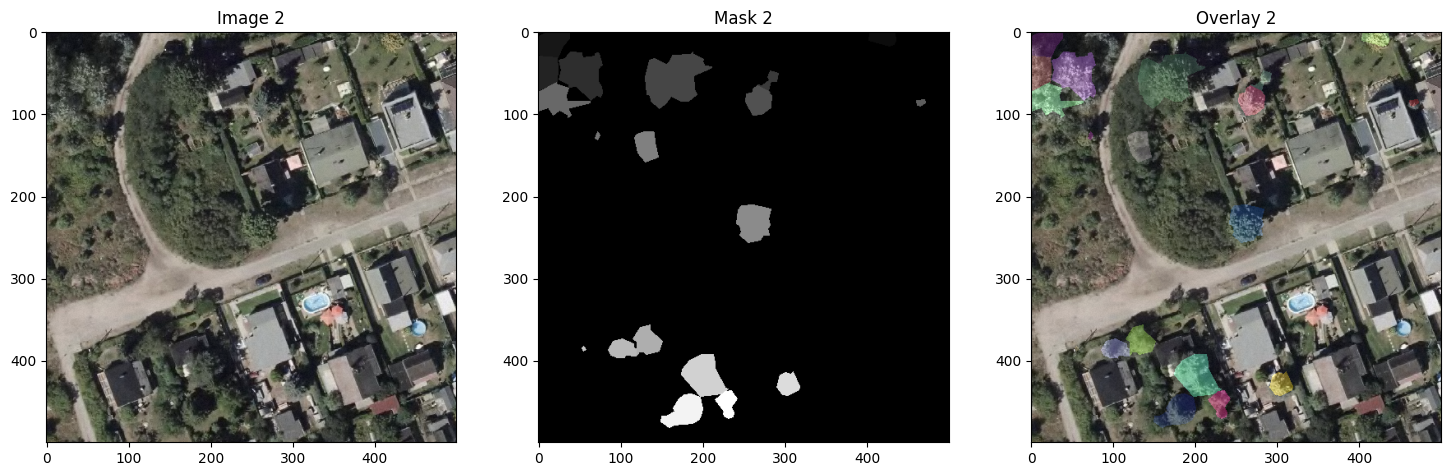

In [ ]:
def visualize_image_and_mask(image_idx, images, masks):
    def normalize_image(image):
        img_norm = image.copy()
        img_norm = cv2.normalize(img_norm, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        return img_norm

    image = images[image_idx]
    mask = masks[image_idx]

    # Normalize the image and mask
    image_normalized = normalize_image(image)
    mask_normalized = normalize_image(mask)
    #image_normalized = image
    #mask_normalized = mask

    # Create a random color map
    num_labels = np.max(mask_normalized) + 1
    random_color_map = np.random.randint(0, 256, (num_labels, 3), dtype=np.uint8)

    # Apply the random color map to the mask
    mask_colored = random_color_map[mask_normalized]

    # Set the alpha channel of the mask layer to 0 for the background pixels
    mask_alpha = np.where(mask_normalized == 0, 0, 1)

    # Create an overlay of the colored mask on the image
    overlay = image_normalized.copy()
    mask_colored_alpha = (mask_colored * mask_alpha[..., None]).astype(np.uint8)
    overlay = cv2.addWeighted(image_normalized, 1, mask_colored_alpha, 0.4, 0)

    # Visualize the original image, the mask, and the overlay
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_normalized)
    ax1.set_title(f'Image {image_idx}')
    ax2.imshow(mask_normalized, cmap='gray')
    ax2.set_title(f'Mask {image_idx}')
    ax3.imshow(overlay)
    ax3.set_title(f'Overlay {image_idx}')
    plt.show()

# Now you can visualize any image and its mask just by calling this function with the desired index: 2, 202, 204, 62
visualize_image_and_mask(2, images, masks)

In [ ]:
# Splitting images, masks, and file names into training and validation sets
X_train, X_val, y_train, y_val, train_filenames, val_filenames = train_test_split(
    images, masks, image_file_names, test_size=0.2, random_state=42
)

In [ ]:
print(len(X_train), len(X_val))

88 23


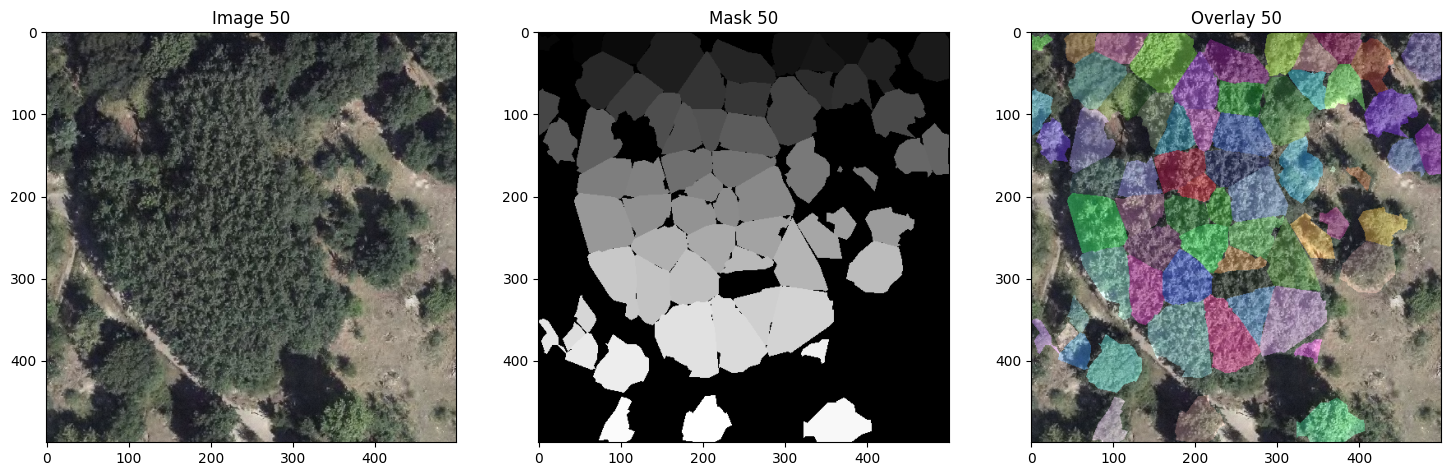

In [ ]:
def visualize_image_and_mask(image_idx, images, masks):
    def normalize_image(image):
        img_norm = image.copy()
        img_norm = cv2.normalize(img_norm, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        return img_norm

    image = images[image_idx]
    mask = masks[image_idx]

    # Normalize the image and mask
    image_normalized = normalize_image(image)
    mask_normalized = normalize_image(mask)
    #image_normalized = image
    #mask_normalized = mask

    # Create a random color map
    num_labels = np.max(mask_normalized) + 1
    random_color_map = np.random.randint(0, 256, (num_labels, 3), dtype=np.uint8)

    # Apply the random color map to the mask
    mask_colored = random_color_map[mask_normalized]

    # Set the alpha channel of the mask layer to 0 for the background pixels
    mask_alpha = np.where(mask_normalized == 0, 0, 1)

    # Create an overlay of the colored mask on the image
    overlay = image_normalized.copy()
    mask_colored_alpha = (mask_colored * mask_alpha[..., None]).astype(np.uint8)
    overlay = cv2.addWeighted(image_normalized, 1, mask_colored_alpha, 0.4, 0)

    # Visualize the original image, the mask, and the overlay
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_normalized)
    ax1.set_title(f'Image {image_idx}')
    ax2.imshow(mask_normalized, cmap='gray')
    ax2.set_title(f'Mask {image_idx}')
    ax3.imshow(overlay)
    ax3.set_title(f'Overlay {image_idx}')
    plt.show()

# Now you can visualize any image and its mask just by calling this function with the desired index: 2, 202, 204, 62
visualize_image_and_mask(50, X_train, y_train)

In [ ]:
# Resize images if needed
#def resize_images(images, size):
#    resized_images = []
#    for img in images:
#        img_resized = cv2.resize(img, (size, size))
#        resized_images.append(img_resized)
#    return resized_images

#size = 250  # Set a smaller size for the images
#X_train_resized = resize_images(X_train, size)
#y_train_resized = resize_images(y_train, size)
#X_val_resized = resize_images(X_val, size)
#y_val_resized = resize_images(y_val, size)

#input_shape = (size, size, 3)

# Train pre-trained R-CNN model

In [ ]:
import torch, detectron2
#!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
if running_in_colab:
    from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
def create_coco_format_dataset(images, masks, image_file_names, output_json_path):
    data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 0, "name": "tree_crown"}]
    }
    annotation_id = 1

    for i, (image, mask) in enumerate(zip(images, masks)):
        height, width, _ = image.shape
        image_file_name = image_file_names[i]

        data["images"].append({
            "id": i,
            "width": width,
            "height": height,
            "file_name": image_file_name
        })

        # Find unique values in the mask (excluding 0 as it is the background)
        unique_values = np.unique(mask)
        unique_values = unique_values[unique_values != 0]

        for unique_value in unique_values:
            # Create a binary mask for the current unique value
            binary_mask = np.uint8(mask == unique_value)

            # Find contours for the binary mask
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                if contour.size < 6:
                    continue  # Skip small contours

                # Flatten the contour and convert it to a list
                contour = np.squeeze(contour)
                segmentation = contour.flatten().tolist()
                bbox = cv2.boundingRect(contour)
                area = cv2.contourArea(contour)

                # Create the annotation dictionary
                annotation = {
                    "id": annotation_id,
                    "image_id": i,
                    "category_id": 0,  # Tree crown category
                    "segmentation": [segmentation],
                    "bbox": bbox,
                    "area": area,
                    "iscrowd": 0
                }
                data["annotations"].append(annotation)
                annotation_id += 1

    # Write the COCO format dataset to a JSON file
    with open(output_json_path, "w") as f:
        json.dump(data, f, indent=4)

In [ ]:
os.makedirs(data_folder, exist_ok=True)

In [ ]:
create_coco_format_dataset(X_train, y_train, train_filenames, os.path.join(data_folder, "train.json"))
create_coco_format_dataset(X_val, y_val, val_filenames, os.path.join(data_folder, "val.json"))

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import load_coco_json

def get_train_data():
    return load_coco_json(os.path.join(data_folder, "train.json"), data_folder)

def get_val_data():
    return load_coco_json(os.path.join(data_folder, "val.json"), data_folder)

# Remove the datasets if they are already registered
if 'my_dataset_train' in DatasetCatalog.list():
    DatasetCatalog.remove('my_dataset_train')

if 'my_dataset_val' in DatasetCatalog.list():
    DatasetCatalog.remove('my_dataset_val')

# Register the datasets and metadata
DatasetCatalog.register("my_dataset_train", get_train_data)
MetadataCatalog.get("my_dataset_train").set(thing_classes=["tree_crown"])
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")

DatasetCatalog.register("my_dataset_val", get_val_data)
MetadataCatalog.get("my_dataset_val").set(thing_classes=["tree_crown"])
my_dataset_val_metadata = MetadataCatalog.get("my_dataset_val")


In [ ]:
from detectron2.config import CfgNode as CN
from detectron2.data import transforms as T

# Add custom data augmentation to the configuration
# Define the custom data augmentation
custom_augmentation_original = [
    T.RandomFlip(horizontal=True, vertical=False),
    T.RandomApply(T.RandomRotation(angle=[90, 90]), prob=0.5),
]

custom_augmentation = [
    T.RandomFlip(horizontal=True, vertical=False),
    T.RandomApply(T.RandomRotation(angle=[0, 90, 180, 270]), prob=0.5),
    T.RandomApply(T.RandomBrightness(0.9, 1.1), prob=0.3),  # Adjust the brightness between 90% and 110%
    T.RandomApply(T.RandomContrast(0.9, 1.1), prob=0.3),  # Adjust the contrast similarly
    T.RandomCrop("relative_range", (0.8, 0.8)),  # Random cropping
    T.RandomApply(T.RandomRotation(angle=[-10, 10], sample_style="range", expand=False), prob=0.2)]

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [1]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg

# Set the max_split_size_mb to potentially reduce fragmentation (this is optional and you might want to try without it first)
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=10'

cfg = get_cfg()

# Backbone configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")

# Dataset setup
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.VAL = ("my_dataset_val",)
#cfg.DATASETS.TEST = ("my_dataset_val",)  # Use validation set for testing
cfg.DATASETS.TEST = ()  # Use validation set for testing

# default cfg
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.MAX_ITER = 3000
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# # Example of adding a learning rate scheduler
# cfg.SOLVER.STEPS = (500, 1500)  # Steps at which to reduce learning rate
# cfg.SOLVER.GAMMA = 0.1  # Factor by which to reduce learning rate

# # Implementing Learning Rate Warmup
# cfg.SOLVER.WARMUP_METHOD = "linear"  # Options: "constant", "linear" or "burnin"
# cfg.SOLVER.WARMUP_ITERS = 1500
# cfg.SOLVER.WARMUP_FACTOR = 0.1

ModuleNotFoundError: No module named 'detectron2'

In [ ]:
# cfg2
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.PATIENCE = 3
cfg.SOLVER.WEIGHT_DECAY = 0.001  # Example value for L2 regularization
# Adjusting batch size and learning rate
cfg.SOLVER.IMS_PER_BATCH = 6  # Reduced from 12
cfg.SOLVER.BASE_LR = 0.0015  # Adjusted in proportion to batch size
cfg.SOLVER.MAX_ITER = 8000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set the number of classes (1 class + 1 for the background)

# Example of adding a learning rate scheduler
cfg.SOLVER.STEPS = (1000, 1500)  # Steps at which to reduce learning rate
cfg.SOLVER.GAMMA = 0.1  # Factor by which to reduce learning rate

# Implementing Learning Rate Warmup
cfg.SOLVER.WARMUP_METHOD = "linear"  # Options: "constant", "linear" or "burnin"
cfg.SOLVER.WARMUP_ITERS = 1500
cfg.SOLVER.WARMUP_FACTOR = 0.1

In [ ]:
# Add the custom data augmentation to the config
cfg.AUGMENTATION = CN()
cfg.AUGMENTATION.TRAIN_PIPELINES = custom_augmentation

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name()}")
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=None, abbreviated=False)
else:
    device = torch.device("cpu")
    cfg.MODEL.DEVICE = 'cpu'
    print("No GPU available, using CPU.")

GPU: Tesla T4


In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 743939 KiB |   4966 MiB | 293986 GiB | 293985 GiB |\n|       from large pool | 663776 KiB |   4865 MiB | 289682 GiB | 289681 GiB |\n|       from small pool |  80162 KiB |    146 MiB |   4303 GiB |   4303 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 743939 KiB |   4966 MiB | 293986 GiB | 293985 GiB |\n|       from large pool | 663776 KiB |   4865 MiB |

In [ ]:
# Load COCO annotation file
annotation_file = os.path.join(data_folder, 'train.json')

with open(annotation_file, 'r') as f:
    data = json.load(f)

# Check each image
missing_files = []
for item in data['images']:
    if not os.path.exists(item['file_name']):
        missing_files.append(item['file_name'])

# Print out missing files
if missing_files:
    print(f"Missing {len(missing_files)} files:")
    for file_name in missing_files:
        print(file_name)
else:
    print("All files exist!")


All files exist!


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [2]:
from detectron2.engine import DefaultTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(cfg.DATASETS.TRAIN)
print(cfg.DATASETS.VAL)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


ModuleNotFoundError: No module named 'detectron2'

In [ ]:
# Get the model from the trainer
trained_model = trainer.model

# Save the trained model
torch.save(trained_model.state_dict(), f"{data_folder}/models/{model_name}")
print("model saved")

model saved


In [ ]:
# with open(f"{data_folder}/models/{model_label}_config.yaml", "w") as f:
#     f.write(cfg.dump())
# print("config saved")

In [ ]:
import yaml
import torch
import os

def convert_cfg_to_dict(cfg):
    """ Convert a config object to a dictionary. """
    cfg_dict = {}
    for k, v in cfg.items():
        try:
            cfg_dict[k] = v
        except TypeError:  # For non-serializable values
            cfg_dict[k] = str(v)  # Convert them to strings
    return cfg_dict

# Save the configuration file
cfg = trainer.cfg  # Assuming 'trainer' has the attribute 'cfg' with the configuration used
cfg_dict = convert_cfg_to_dict(cfg)

cfg_file_path = os.path.join(data_folder, "models", f"{model_label}_config2.yaml")
with open(cfg_file_path, 'w') as f:
    yaml.dump(cfg_dict, f, default_flow_style=False)  # Saving the configuration as a YAML file

# print(f"Config file saved to {cfg_file_path}")

In [ ]:
print(cfg.OUTPUT_DIR)

./output


In [ ]:
# Configuration
metrics_file = '/content/output/metrics.json'  # Path to the metrics.json file
#metrics_file = '/content/drive/MyDrive/detectron2/output/metrics.json'  # Path to the metrics.json file

# Create the directory if it doesn't exist
output_directory = os.path.join(data_folder, 'models')
os.makedirs(output_directory, exist_ok=True)

# Load the data
with open(metrics_file) as f:
    metrics_data = [json.loads(line) for line in f]

# Convert to DataFrame
df = pd.DataFrame(metrics_data)

# Fill missing values
df.ffill(inplace=True)

# Identify all metric columns (exclude 'iteration' column)
metric_columns = df.columns.drop('iteration')

# Plotting and saving each metric
for metric in metric_columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df['iteration'], df[metric], label=f'{metric}')
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.title(f'{metric} over Iterations')
    plt.legend()
    plt.grid(True)
    metric_name = metric.replace('/', '_').replace('\\', '_')

    # Save the plot
    plot_filename = f"{model_name}_{metric_name}.png"
    plt.savefig(os.path.join(output_directory, plot_filename))
    plt.close()

print(f"All plots saved in {output_directory}")


All plots saved in /content/drive/MyDrive/data/400_5816/models


## Evaluaton

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)
print(cfg.MODEL.WEIGHTS)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # Set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val",)
predictor = DefaultPredictor(cfg)

# Perform evaluation
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(predictor.model, val_loader, evaluator)


/content/drive/MyDrive/data/400_5816/models/model_aoi400_5816_70p_8000i_augm_cfg2.pth
[07/12 22:48:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/data/400_5816/models/model_aoi400_5816_70p_8000i_augm_cfg2.pth ...
[07/12 22:48:57 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [07/12 22:48:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/12 22:48:57 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/drive/MyDrive/data/400_5816/val.json
[07/12 22:48:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/12 22:48:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/12 22:48:57 d2.data.common]

OrderedDict([('bbox',
              {'AP': 6.414050636763048,
               'AP50': 23.960850187559195,
               'AP75': 1.2716612192595464,
               'APs': 5.93642541550867,
               'APm': 6.885184083847837,
               'APl': nan}),
             ('segm',
              {'AP': 4.077046333341625,
               'AP50': 16.09769126584038,
               'AP75': 0.4571870931366419,
               'APs': 2.6232081592002197,
               'APm': 4.4070128740459555,
               'APl': nan})])

In [ ]:
import shutil

# Source files
src_coco_instances = '/content/output/coco_instances_results.json'
src_metrics = '/content/output/metrics.json'

# Destination directory
output_directory = os.path.join(data_folder, 'models')
os.makedirs(output_directory, exist_ok=True)

# Destination file paths
dest_coco_instances = os.path.join(output_directory, f"{model_name}_coco_instances_results.json")
dest_metrics = os.path.join(output_directory, f"{model_name}_metrics.json")

# Copy files
shutil.copy(src_coco_instances, dest_coco_instances)
shutil.copy(src_metrics, dest_metrics)
print(dest_coco_instances)

print(f"Files copied to {output_directory}")


/content/drive/MyDrive/data/400_5816/models/model_aoi400_5816_70p_3000i.pth_coco_instances_results.json
Files copied to /content/drive/MyDrive/data/400_5816/models


In [ ]:
#from detectron2.engine import DefaultTrainer
#trainer = DefaultTrainer(cfg)
#coco_eval = trainer.test(cfg, trainer.model)

Intersection over Union (IoU) is a metric used to evaluate the performance of object detection models. It measures the overlap between the predicted bounding box and the ground truth bounding box. The IoU is calculated as the area of intersection divided by the area of union of the two bounding boxes.

The IoU threshold is a value that defines the minimum acceptable IoU for a predicted bounding box to be considered a true positive (a correct detection). For example, if the IoU threshold is set to 0.5, any predicted bounding box with an IoU of 0.5 or higher with respect to the ground truth bounding box will be considered a true positive.

When evaluating object detection models, it is common to calculate the Average Precision (AP) at various IoU thresholds to see how well the model performs across different levels of overlap between the predicted and ground truth bounding boxes. This provides a more comprehensive view of the model's performance, as the AP might be higher for lower IoU thresholds and lower for higher IoU thresholds.

For segmentation models, a desirable IoU value depends on the specific application and the level of accuracy required. In general, higher IoU values indicate better performance. Here are some general guidelines:

- IoU > 0.9: Excellent performance, with very high overlap between the predicted and ground truth segments.
- IoU between 0.75 and 0.9: Good performance, with a reasonable overlap between the predicted and ground truth segments.
- IoU between 0.5 and 0.75: Moderate performance, with some overlap between the predicted and ground truth segments, but room for improvement.
- IoU < 0.5: Poor performance, with low overlap between the predicted and ground truth segments.

For many applications, an IoU value above 0.75 is considered satisfactory. However, more stringent requirements might demand higher IoU values (e.g., medical image segmentation, where a high level of accuracy is crucial). It's important to consider the context and requirements of the specific application when determining an acceptable IoU value.

[07/12 18:11:55 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [07/12 18:11:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/12 18:11:55 d2.evaluation.evaluator]: Start inference on 23 batches
[07/12 18:11:57 d2.evaluation.evaluator]: Inference done 11/23. Dataloading: 0.0013 s/iter. Inference: 0.1016 s/iter. Eval: 0.0435 s/iter. Total: 0.1464 s/iter. ETA=0:00:01
[07/12 18:11:58 d2.evaluation.evaluator]: Total inference time: 0:00:02.694526 (0.149696 s / iter per device, on 1 devices)
[07/12 18:11:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.102141 s / iter per device, on 1 devices)
[07/12 18:11:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/12 18:11:58 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[07/12 18:11:59 d2.evaluation

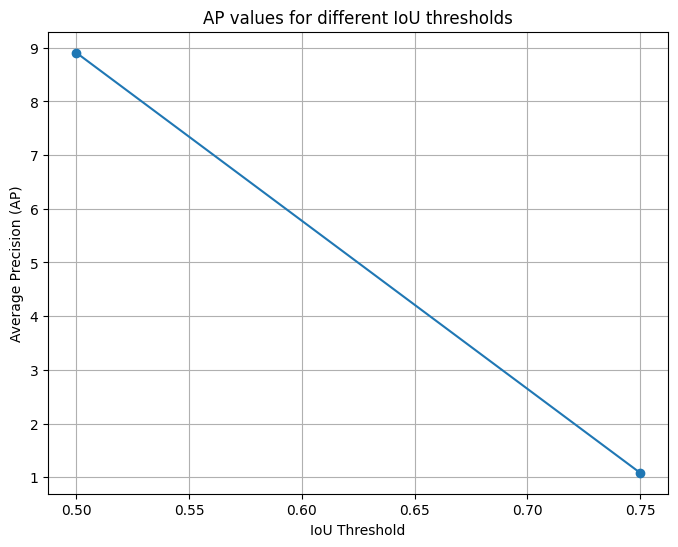

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Load the validation dataset
#val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])

# Create the COCOEvaluator
coco_evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=cfg.OUTPUT_DIR)

# Perform the evaluation
#results = inference_on_dataset(trainer.model, val_loader, coco_evaluator)
results = inference_on_dataset(predictor.model, val_loader, coco_evaluator)
#print(metrics)

# Access the COCO evaluation results
coco_eval = coco_evaluator._results["segm"]

# IoU thresholds for 'AP50', and 'AP75' respectively
iou_thresholds = np.array([0.5, 0.75])

# Corresponding AP values
ap_values = np.array([coco_eval['AP50'], coco_eval['AP75']])

# Plot AP values for the specified IoU thresholds
plt.figure(figsize=(8, 6))
plt.plot(iou_thresholds, ap_values, marker='o')
plt.xlabel("IoU Threshold")
plt.ylabel("Average Precision (AP)")
plt.title("AP values for different IoU thresholds")
plt.grid()
plt.show()

# Test on new data

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import cv2

# Load the trained model
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20 # Set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

# Load a new image for inference
new_image_path = "/content/drive/MyDrive/data/test_imgs/382_5826_9_6.tif"
#new_image = cv2.imread(new_image_path)
with rasterio.open(new_image_path) as src:
        new_image = src.read().transpose(1, 2, 0)[:, :, :3]
        new_image = cv2.normalize(new_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Make predictions
outputs = predictor(new_image)

# Visualize the predictions
v = Visualizer(new_image[:, :, ::-1],
               metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite("/content/drive/MyDrive/data/predicted_image.jpg", v.get_image()[:, :, ::-1])


[07/12 17:18:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/data/400_5816/models/model_aoi400_5816_70p_8000i_aug.pth ...


True

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Instances
import cv2

def filter_by_size(predictions: Instances, max_area: int):
    if "pred_masks" in predictions._fields:
        areas = predictions.pred_masks.sum(dim=[1,2]).cpu().numpy()
    else:
        boxes = predictions.pred_boxes.tensor
        areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

    keep = areas < max_area
    return predictions[torch.tensor(keep)]


# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.10
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

# Load a new image for inference
new_image_path = "/content/drive/MyDrive/data/test_imgs/382_5826_9_6.tif"
with rasterio.open(new_image_path) as src:
    new_image = src.read().transpose(1, 2, 0)[:, :, :3]
    new_image = cv2.normalize(new_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Make predictions
outputs = predictor(new_image)
# Visualize the predictions
v = Visualizer(new_image[:, :, ::-1],
               metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite("/content/drive/MyDrive/data/predicted_image.jpg", v.get_image()[:, :, ::-1])

[07/12 17:18:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/data/400_5816/models/model_aoi400_5816_70p_8000i_aug.pth ...


True

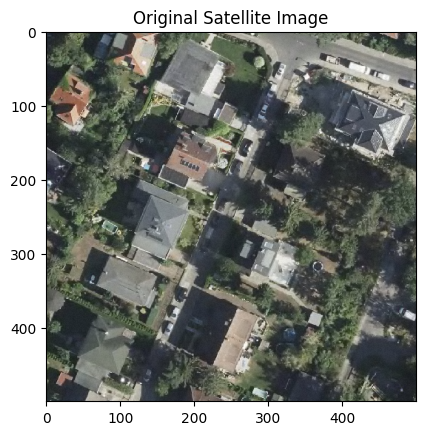

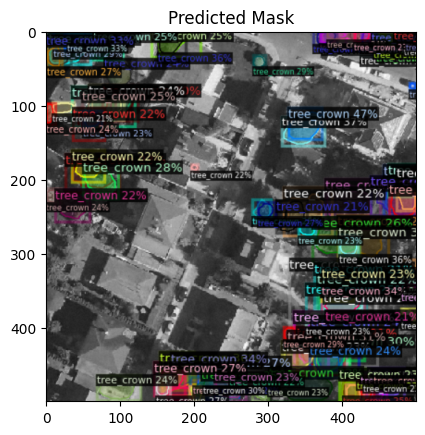

In [ ]:
# Plot the original satellite image
plt.imshow(new_image)
plt.title("Original Satellite Image")
plt.show()

# Scale the predicted mask to the original image size
predicted_mask_rescaled = cv2.resize(v.get_image()[:, :, ::-1], (new_image.shape[1], new_image.shape[0]))

# Plot the predicted mask
plt.imshow(predicted_mask_rescaled)
plt.title("Predicted Mask")
plt.show()


In [ ]:
with open(transform_json_path, "r") as f:
    transform_data = json.load(f)
transform = rasterio.transform.Affine(*transform_data["transform"])

In [ ]:
# Get predicted masks
masks = outputs["instances"].pred_masks.cpu().numpy()

# Create an empty GeoDataFrame
gdf = gpd.GeoDataFrame(columns=["id", "geometry"])

# Iterate through the masks and add them as features to the GeoDataFrame
for i, mask in enumerate(masks):
    contours, _ = cv2.findContours((mask * 255).astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for contour in contours:
        contour = contour.squeeze()
        if contour.size < 6:  # A contour should have at least 3 points (x, y) to form a valid polygon
            continue

        # Apply the inverse transformation to the contour points to obtain georeferenced coordinates
        contour_georef = rasterio.transform.xy(transform=transform, rows=contour[:, 1], cols=contour[:, 0])
        contour_coords = list(zip(contour_georef[0], contour_georef[1]))

        # Check if contour_georef contains valid data
        if len(contour_georef[0]) < 3 or len(contour_georef[1]) < 3:
            continue

        # Create a polygon from the contour points
        polygon = Polygon(contour_coords)

        # Add the polygon as a feature to the GeoDataFrame
        # gdf = gdf.append({"id": i, "geometry": polygon}, ignore_index=True)
        gdf.loc[len(gdf)] = [i, polygon]

# Set the original CRS to EPSG:25833
gdf.crs = "EPSG:25833"

# Save the GeoDataFrame as a GeoJSON file
output_geojson_path = os.path.join(data_folder, "predicted_tree_crowns_EPSG25833.geojson")

gdf.to_file(output_geojson_path, driver="GeoJSON")

In [ ]:
from rasterio.transform import Affine
# Extract polygon coordinates from the prediction
instances = outputs['instances'].to('cpu')
masks = instances.pred_masks.numpy()

polygons = []
for mask in masks:
    # Convert the mask to polygon using rasterio
    shapes = rasterio.features.shapes(mask.astype(np.uint8), mask=mask)
    for shape, value in shapes:
        if value == 1:
            # Create a polygon from the shape's coordinates
            polygon = Polygon(shape['coordinates'][0])
            polygons.append(polygon)

# Convert pixel coordinates to geographic coordinates using the provided affine transformation
transform = Affine(0.20, 0.00, 382000.00, 0.00, -0.20, 5827000.00)

polygons_geo = []
for polygon in polygons:
    polygon_geo_coords = [transform * coord for coord in polygon.exterior.coords]
    polygons_geo.append(Polygon(polygon_geo_coords))

# Create a GeoDataFrame with the polygon geometries
gdf = gpd.GeoDataFrame(geometry=polygons_geo, crs='EPSG:25833')

output_geojson_path = os.path.join(data_folder, "predicted_tree_crowns_EPSG25833_al2.geojson")


# Save the GeoDataFrame as a vector file (e.g., GeoJSON)
gdf.to_file("output_geojson_path", driver="GeoJSON")


# Investigation
## Verify annotation

In [ ]:
# Load and Inspect the JSON Annotation File
import json

# Path to your COCO formatted JSON file
annotation_file = '/content/drive/MyDrive/data/382_5826_1/train.json'

# Load the annotations
with open(annotation_file, 'r') as f:
    coco_annotations = json.load(f)

# Check the keys in the loaded JSON
print(coco_annotations.keys())


dict_keys(['images', 'annotations', 'categories'])


In [ ]:
# Inspect the Categories
for category in coco_annotations['categories']:
    print(category)

{'id': 0, 'name': 'tree_crown'}


In [ ]:
# Make sure that each annotation has an image_id that links it to an image, and a category_id
for annotation in coco_annotations['annotations'][:10]:  # Inspect first 10 annotations
    print(annotation)

{'id': 1, 'image_id': 0, 'category_id': 0, 'segmentation': [[377, 0, 376, 1, 375, 1, 374, 2, 372, 2, 371, 3, 371, 6, 372, 7, 372, 9, 373, 10, 373, 11, 374, 12, 374, 13, 375, 14, 375, 16, 374, 17, 374, 18, 373, 19, 373, 21, 372, 22, 373, 23, 373, 24, 377, 28, 377, 30, 376, 31, 376, 34, 375, 35, 375, 37, 376, 38, 376, 39, 378, 41, 379, 40, 380, 40, 382, 38, 383, 38, 384, 37, 385, 37, 387, 35, 388, 35, 390, 33, 391, 33, 392, 32, 392, 31, 393, 30, 393, 27, 394, 26, 394, 24, 393, 23, 393, 22, 396, 19, 396, 18, 399, 15, 400, 15, 401, 16, 402, 16, 403, 17, 404, 17, 405, 18, 408, 18, 409, 17, 410, 17, 411, 18, 411, 19, 412, 20, 412, 21, 414, 23, 414, 24, 416, 26, 416, 27, 417, 28, 417, 29, 418, 30, 417, 29, 417, 28, 416, 27, 416, 26, 415, 25, 415, 24, 414, 23, 414, 22, 413, 21, 413, 20, 412, 19, 412, 18, 411, 17, 412, 16, 413, 16, 414, 15, 415, 15, 416, 14, 417, 14, 418, 13, 419, 13, 420, 12, 421, 12, 422, 11, 423, 11, 424, 10, 424, 8, 425, 7, 426, 7, 427, 6, 431, 6, 432, 5, 434, 5, 438, 1, 41

In [ ]:
# Ensure every image in the images field has at least one corresponding annotation
image_ids_with_annotations = set([ann['image_id'] for ann in coco_annotations['annotations']])
all_image_ids = set([img['id'] for img in coco_annotations['images']])
print("Images without annotations:", all_image_ids - image_ids_with_annotations)


Images without annotations: set()


In [ ]:
# Assuming coco_annotations['images'] is a list of images with 'id' and 'file_name' as keys.
image_dict = {image['id']: image['file_name'] for image in coco_annotations['images']}

# Validate Object Sizes
for annotation in coco_annotations['annotations']:
    bbox = annotation['bbox']
    area = bbox[2] * bbox[3]  # width * height
    image_id = annotation['image_id']
    image_path = image_dict.get(image_id, 'Image ID not found')  # Get the image path using the image ID.

    # COCO default thresholds for object sizes
    if area < 32**2:
        size = 'small'
    elif area < 96**2:
        size = 'medium'
    else:
        size = 'large'
        print(f"Object size for annotation {annotation['id']} on image: {image_id}: {size} - {area}, Image Path: {image_path}")


Object size for annotation 13 on image: 0: large - 9810, Image Path: /content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_382_5826_1_be_3_6.tif
Object size for annotation 14 on image: 0: large - 11664, Image Path: /content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_382_5826_1_be_3_6.tif
Object size for annotation 19 on image: 0: large - 9600, Image Path: /content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_382_5826_1_be_3_6.tif
Object size for annotation 73 on image: 1: large - 10094, Image Path: /content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_382_5826_1_be_9_4.tif
Object size for annotation 95 on image: 1: large - 11232, Image Path: /content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_382_5826_1_be_9_4.tif
Object size for annotation 138 on image: 4: large - 11770, Image Path: /content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_383_5827_1_be_1_4.tif
Object size for annotation 139 on image: 4: large - 10165, Image 

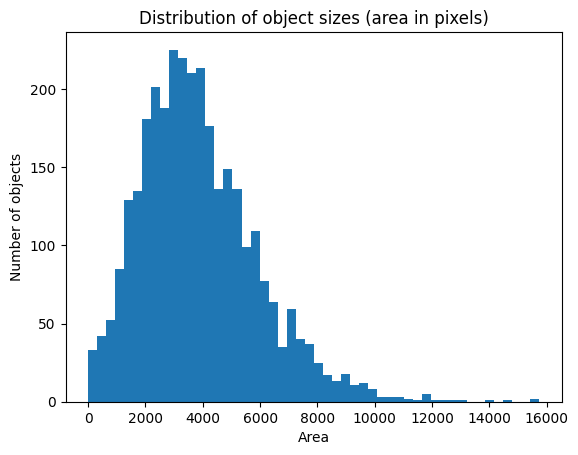

In [ ]:
import matplotlib.pyplot as plt

sizes = []
for annotation in coco_annotations['annotations']:
    bbox = annotation['bbox']
    area = bbox[2] * bbox[3]
    sizes.append(area)

plt.hist(sizes, bins=50)
plt.title('Distribution of object sizes (area in pixels)')
plt.xlabel('Area')
plt.ylabel('Number of objects')
plt.show()


/content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_383_5827_1_be_1_4.tif


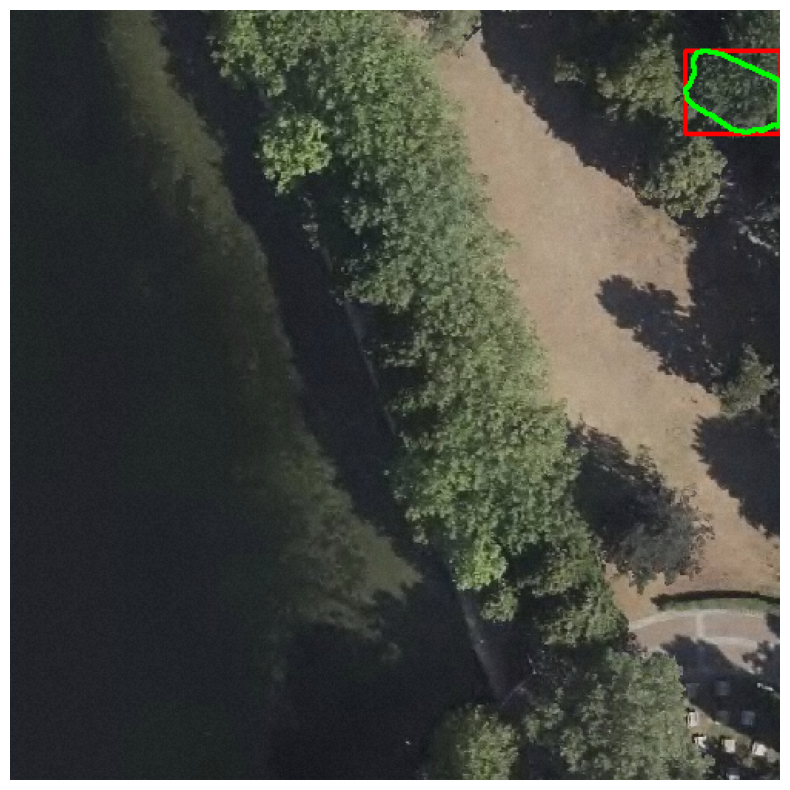

In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import json

# Function to draw bounding box and segmentation
def visualize_annotation_by_id(annotation_id, annotations_data):
    # Find the specific annotation by ID
    annotation = next((ann for ann in annotations_data['annotations'] if ann['id'] == annotation_id), None)
    if annotation:
        # Get the corresponding image info
        image_info = next((img for img in annotations_data['images'] if img['id'] == annotation['image_id']), None)
        if not image_info:
            print(f"No image found for annotation ID {annotation_id}")
            return
        image_path = image_info['file_name']
        print(image_info['file_name'])

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image at path {image_path} not found.")
            return
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw bounding box, bbox = [x,y,width,height]
        bbox = annotation['bbox']
        start_point = (int(bbox[0]), int(bbox[1]))
        end_point = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        image = cv2.rectangle(image, start_point, end_point, (255, 0, 0), 2)

        # Draw segmentation, segmentation = [[polygon points], ...]
        segmentation = annotation['segmentation']
        for segment in segmentation:
            poly = np.array(segment, dtype=np.int32).reshape((-1, 1, 2))
            image = cv2.polylines(image, [poly], True, (0, 255, 0), 2)

        # Show the image with matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        print(f"No annotation found with ID {annotation_id}")


# Load annotations from a JSON file into a dictionary
with open(annotation_file, 'r') as f:
    annotations_data = json.load(f)

# Specify the annotation ID you want to visualize
annotation_id_to_visualize = 134 # 4692 #4672 # 201, 3152, 201, 9823

# Call the function to visualize the annotation
visualize_annotation_by_id(annotation_id_to_visualize, annotations_data)


In [ ]:
import json

# Load your annotations file
with open(annotation_file, 'r') as file:
    annotations_data = json.load(file)

# Print the keys for annotations
if 'annotations' in annotations_data:
    print("Annotation keys:", annotations_data['annotations'][0].keys())

# Print the keys for images
if 'images' in annotations_data:
    print("Image keys:", annotations_data['images'][0].keys())

# Print the keys for categories
if 'categories' in annotations_data:
    print("Category keys:", annotations_data['categories'][0].keys())


Annotation keys: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'bbox', 'area', 'iscrowd'])
Image keys: dict_keys(['id', 'width', 'height', 'file_name'])
Category keys: dict_keys(['id', 'name'])
